Analysis of the climate variables from ERA5 data

In [2]:
#Import packages
import os
import earthpy as et
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator

In [90]:
#Set path to where the data is
CITY_COUNTRY = 'BULAWAYO_ZIMBABWE'     ##this needs to be manually changed to define which city 

######################################################################################################
#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
#set the city latitude and longitudes
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'].values[0]
#set the directory
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))

#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)

#open file
clim_ds = xr.open_dataset(filename)

#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25

#add in date column to the variables
clim_ds['date'] = clim_ds['time']

temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')

subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')

#send to dataframe
clim_df = subset_clim_ds.to_dataframe()

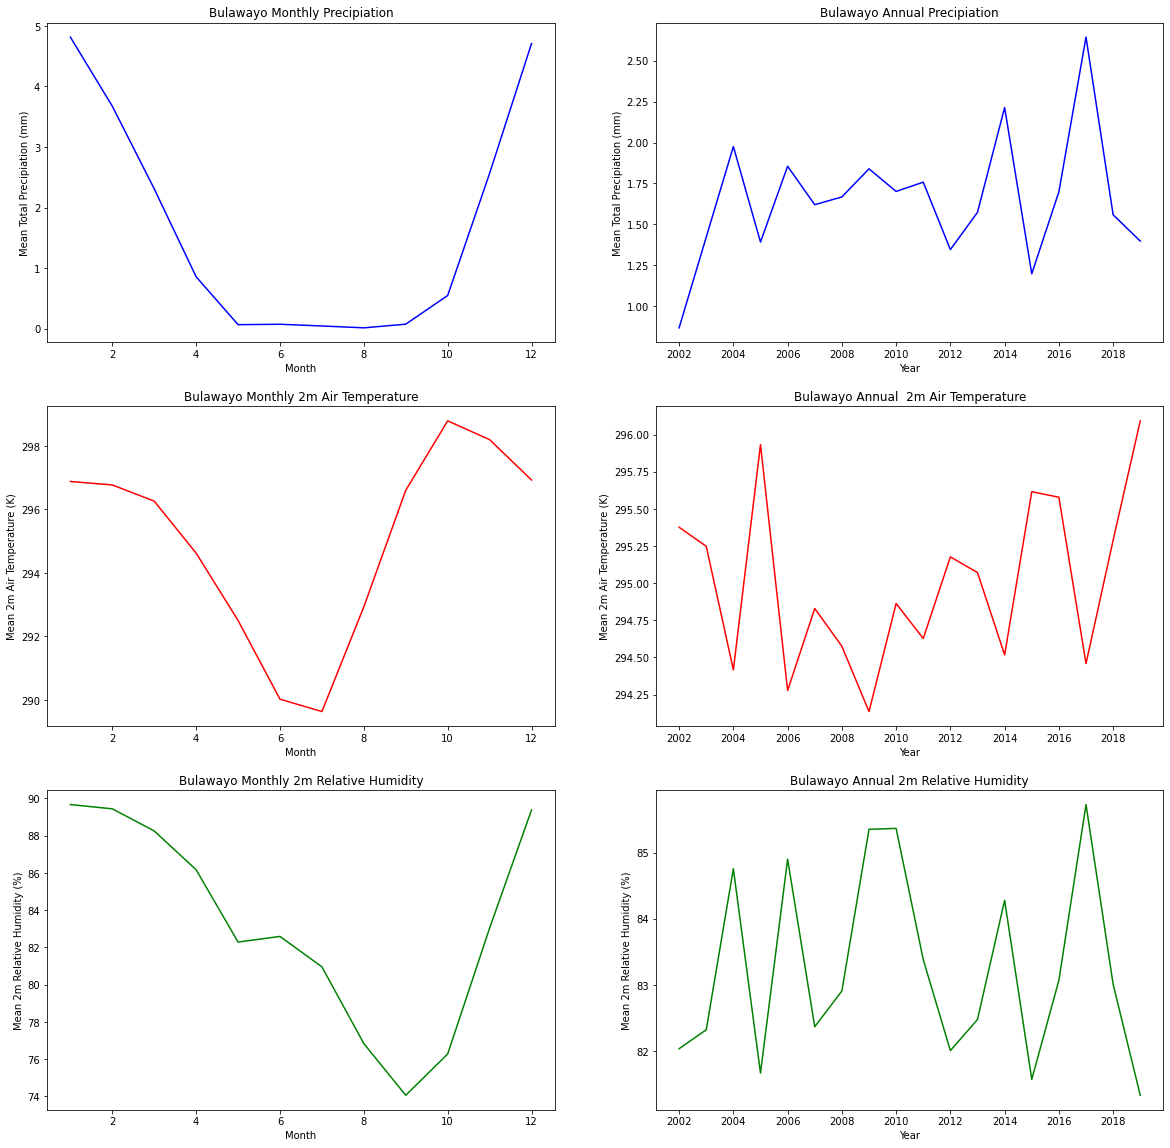

In [91]:
#get averages: precip, 2m air temp
#then plot                         
#Extract the months and years from the date
date2 = pd.DatetimeIndex(clim_df['date'])
clim_df['date2']= date2
clim_df['month'] = date2.month
clim_df['year'] = date2.year

#Add in the relative humidity
def calc_rh(x):
    a = 17.67
    b = 243.5
    rh = 100* np.exp(a*x["d2m"]/(b+x["d2m"]))/ np.exp(a*x["t2m"]/(b+x["t2m"]))
    return rh

clim_df["rh"] = calc_rh(clim_df)

#group by month/ year to get means
g_mon = clim_df.groupby(["month"])
monthly_averages = g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})

g_yr = clim_df.groupby(["year"])
yearly_averages = g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})

#remove 2020 from the annual averages as data only goes up to October 2020. Will skew 2020
yearly_averages.drop(yearly_averages.tail(1).index,inplace=True) # drop last row


#plot monthly and yearly precip, air temp 2m, relative humidity, skin temperature

fig, axes = plt.subplots(nrows = 3,ncols = 2, figsize=(20, 20))

axes[0,0].plot(1000*monthly_averages.tp, 'b')
axes[0,0].set_title('{} Monthly Precipiation'.format(City_name))
axes[0,0].set(xlabel = 'Month', ylabel = 'Mean Total Precipiation (mm)')

axes[0,1].plot(1000*yearly_averages.tp, 'b')
axes[0,1].set_title('{} Annual Precipiation'.format(City_name))
axes[0,1].set(xlabel = 'Year', ylabel = 'Mean Total Precipiation (mm)')

axes[1,0].plot(monthly_averages.t2m, 'r')
axes[1,0].set_title('{} Monthly 2m Air Temperature'.format(City_name))
axes[1,0].set(xlabel = 'Month', ylabel = 'Mean 2m Air Temperature (K)')

axes[1,1].plot(yearly_averages.t2m, 'r')
axes[1,1].set_title('{} Annual  2m Air Temperature'.format(City_name))
axes[1,1].set(xlabel = 'Year', ylabel = 'Mean 2m Air Temperature (K)')

axes[2,0].plot(monthly_averages.rh, 'g')
axes[2,0].set_title('{} Monthly 2m Relative Humidity'.format(City_name))
axes[2,0].set(xlabel = 'Month', ylabel = 'Mean 2m Relative Humidity (%)')

axes[2,1].plot(yearly_averages.rh, 'g')
axes[2,1].set_title('{} Annual 2m Relative Humidity'.format(City_name))
axes[2,1].set(xlabel = 'Year', ylabel = 'Mean 2m Relative Humidity (%)')


xa = axes[0,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
xa = axes[1,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[2,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 

#save the plot as a png
plt.savefig('era5_clim_trends.png')

Plot the climate information for multiple cities on the same plot

In [5]:
CITY_COUNTRY = 'HUAMBO_ANGOLA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Huambo_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'ANAPOLIS_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Anapolis_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'CUIABA_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Cuiaba_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'FRANCA_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Franca_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'MARINGA_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Maringa_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'PIRACICABA_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Piracicaba_clim_df = subset_clim_ds.to_dataframe()


CITY_COUNTRY = 'RIBEIRAO_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Ribeirao_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'SAO_JOSE_DO_RIO_PRETO_BRAZIL'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Sao_Jose_Do_Rio_Preto_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'LINQING_CHINA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Linqing_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'ASYUT_EGYPT'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Asyut_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'AKOLA_INDIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Akola_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'ERODE_INDIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Erode_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'HISAR_INDIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Hisar_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'PARBHANI_INDIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Parbhani_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'SATNA_INDIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Satna_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'SHAHJAHANPUR_INDIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Shahjahanpur_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'BLOEMFONTEIN_SOUTH_AFRICA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Bloemfontein_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'AL_GADARIF_SUDAN'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Al_Gadarif_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'KASSALA_SUDAN'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Kassala_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'SPOKANE_UNITED_STATES'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Spokane_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'NDOLA_ZAMBIA'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Ndola_clim_df = subset_clim_ds.to_dataframe()

CITY_COUNTRY = 'BULAWAYO_ZIMBABWE'
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'ERA5', CITY_COUNTRY))
#file
filename = '{}_2002_2020.nc'.format(CITY_COUNTRY)
#open file
clim_ds = xr.open_dataset(filename)
#bounds to look at
#Area to look at will be the city centre +/- 0.25 degs?
min_lat = City_Lat - 0.25
max_lat = City_Lat + 0.25
min_lon = City_Lon - 0.25
max_lon = City_Lon + 0.25
#add in date column to the variables
clim_ds['date'] = clim_ds['time']
temp_ds = clim_ds.sel(latitude =(clim_ds.latitude > min_lat) & (clim_ds.latitude < max_lat), method = 'nearest')
subset_clim_ds = temp_ds.sel(longitude =(temp_ds.longitude >min_lon) & (temp_ds.longitude < max_lon), method = 'nearest')
#send to dataframe
Bulawayo_clim_df = subset_clim_ds.to_dataframe()

In [6]:
Huambo_clim_df

d2m         t2m            tp       date
latitude longitude time                                                       
-12.0    15.0      2002-01-01  288.459595  290.806671  9.621179e-03 2002-01-01
                   2002-02-01  288.787964  291.492401  8.592837e-03 2002-02-01
                   2002-03-01  289.385895  291.620758  1.214609e-02 2002-03-01
                   2002-04-01  288.703094  291.818604  6.931010e-03 2002-04-01
                   2002-05-01  282.709473  291.778229  7.329974e-06 2002-05-01
...                                   ...         ...           ...        ...
                   2020-06-01  278.060577  291.048767  6.817281e-07 2020-06-01
                   2020-07-01  274.950562  290.851257  9.192154e-07 2020-07-01
                   2020-08-01  280.838104  292.886993  1.063412e-04 2020-08-01
                   2020-09-01  284.118561  293.402039  1.295429e-03 2020-09-01
                   2020-10-01  288.474915  292.925751  7.425118e-03 2020-10-01

[99666 rows x 4 columns]

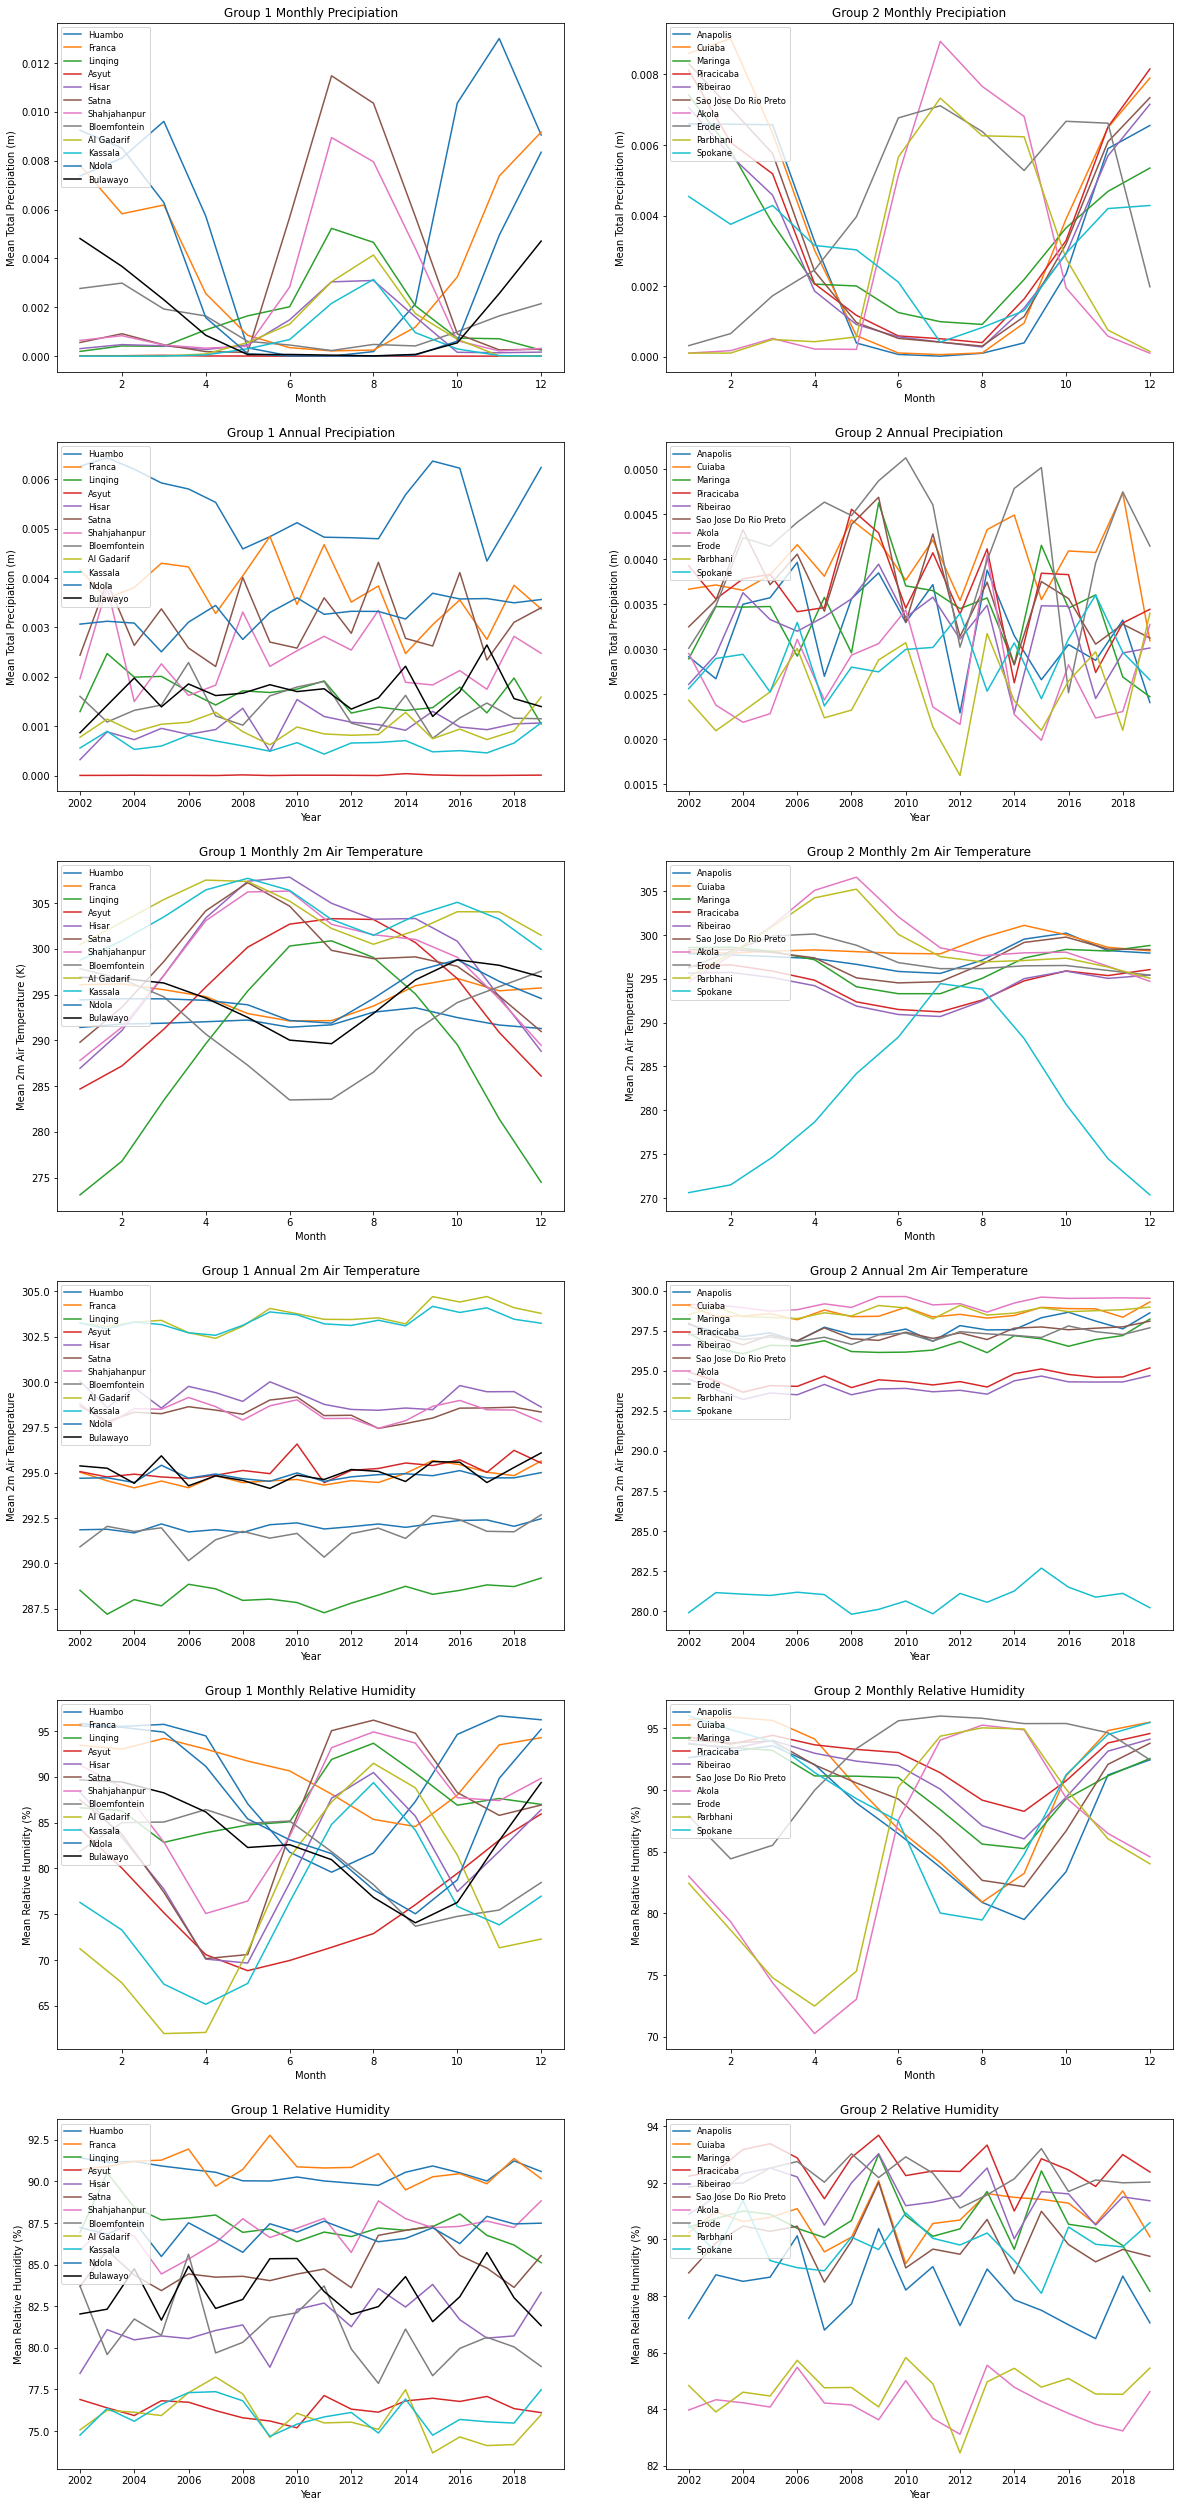

In [7]:
#get averages: precip, 2m air temp
#then plot on same axes                         
#Extract the months and years from the date
date2 = pd.DatetimeIndex(Huambo_clim_df['date'])
Huambo_clim_df['date2']= date2
Huambo_clim_df['month'] = date2.month
Huambo_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Anapolis_clim_df['date'])
Anapolis_clim_df['date2']= date2
Anapolis_clim_df['month'] = date2.month
Anapolis_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Cuiaba_clim_df['date'])
Cuiaba_clim_df['date2']= date2
Cuiaba_clim_df['month'] = date2.month
Cuiaba_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Franca_clim_df['date'])
Franca_clim_df['date2']= date2
Franca_clim_df['month'] = date2.month
Franca_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Maringa_clim_df['date'])
Maringa_clim_df['date2']= date2
Maringa_clim_df['month'] = date2.month
Maringa_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Piracicaba_clim_df['date'])
Piracicaba_clim_df['date2']= date2
Piracicaba_clim_df['month'] = date2.month
Piracicaba_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Ribeirao_clim_df['date'])
Ribeirao_clim_df['date2']= date2
Ribeirao_clim_df['month'] = date2.month
Ribeirao_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Sao_Jose_Do_Rio_Preto_clim_df['date'])
Sao_Jose_Do_Rio_Preto_clim_df['date2']= date2
Sao_Jose_Do_Rio_Preto_clim_df['month'] = date2.month
Sao_Jose_Do_Rio_Preto_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Linqing_clim_df['date'])
Linqing_clim_df['date2']= date2
Linqing_clim_df['month'] = date2.month
Linqing_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Asyut_clim_df['date'])
Asyut_clim_df['date2']= date2
Asyut_clim_df['month'] = date2.month
Asyut_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Akola_clim_df['date'])
Akola_clim_df['date2']= date2
Akola_clim_df['month'] = date2.month
Akola_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Erode_clim_df['date'])
Erode_clim_df['date2']= date2
Erode_clim_df['month'] = date2.month
Erode_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Hisar_clim_df['date'])
Hisar_clim_df['date2']= date2
Hisar_clim_df['month'] = date2.month
Hisar_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Parbhani_clim_df['date'])
Parbhani_clim_df['date2']= date2
Parbhani_clim_df['month'] = date2.month
Parbhani_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Satna_clim_df['date'])
Satna_clim_df['date2']= date2
Satna_clim_df['month'] = date2.month
Satna_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Shahjahanpur_clim_df['date'])
Shahjahanpur_clim_df['date2']= date2
Shahjahanpur_clim_df['month'] = date2.month
Shahjahanpur_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Bloemfontein_clim_df['date'])
Bloemfontein_clim_df['date2']= date2
Bloemfontein_clim_df['month'] = date2.month
Bloemfontein_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Al_Gadarif_clim_df['date'])
Al_Gadarif_clim_df['date2']= date2
Al_Gadarif_clim_df['month'] = date2.month
Al_Gadarif_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Kassala_clim_df['date'])
Kassala_clim_df['date2']= date2
Kassala_clim_df['month'] = date2.month
Kassala_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Spokane_clim_df['date'])
Spokane_clim_df['date2']= date2
Spokane_clim_df['month'] = date2.month
Spokane_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Ndola_clim_df['date'])
Ndola_clim_df['date2']= date2
Ndola_clim_df['month'] = date2.month
Ndola_clim_df['year'] = date2.year

date2 = pd.DatetimeIndex(Bulawayo_clim_df['date'])
Bulawayo_clim_df['date2']= date2
Bulawayo_clim_df['month'] = date2.month
Bulawayo_clim_df['year'] = date2.year

#Add in the relative humidity
def calc_rh(x):
    a = 17.67
    b = 243.5
    rh = 100* np.exp(a*x["d2m"]/(b+x["d2m"]))/ np.exp(a*x["t2m"]/(b+x["t2m"]))
    return rh

Huambo_clim_df["rh"] = calc_rh(Huambo_clim_df)
Anapolis_clim_df["rh"] = calc_rh(Anapolis_clim_df)
Cuiaba_clim_df["rh"] = calc_rh(Cuiaba_clim_df)
Franca_clim_df["rh"] = calc_rh(Franca_clim_df)
Maringa_clim_df["rh"] = calc_rh(Maringa_clim_df)
Piracicaba_clim_df["rh"] = calc_rh(Piracicaba_clim_df)
Ribeirao_clim_df["rh"] = calc_rh(Ribeirao_clim_df)
Sao_Jose_Do_Rio_Preto_clim_df["rh"] = calc_rh(Sao_Jose_Do_Rio_Preto_clim_df)
Linqing_clim_df["rh"] = calc_rh(Linqing_clim_df)
Asyut_clim_df["rh"] = calc_rh(Asyut_clim_df)
Akola_clim_df["rh"] = calc_rh(Akola_clim_df)
Erode_clim_df["rh"] = calc_rh(Erode_clim_df)
Hisar_clim_df["rh"] = calc_rh(Hisar_clim_df)
Parbhani_clim_df["rh"] = calc_rh(Parbhani_clim_df)
Satna_clim_df["rh"] = calc_rh(Satna_clim_df)
Shahjahanpur_clim_df["rh"] = calc_rh(Shahjahanpur_clim_df)
Bloemfontein_clim_df["rh"] = calc_rh(Bloemfontein_clim_df)
Al_Gadarif_clim_df["rh"] = calc_rh(Al_Gadarif_clim_df)
Kassala_clim_df["rh"] = calc_rh(Kassala_clim_df)
Spokane_clim_df["rh"] = calc_rh(Spokane_clim_df)
Ndola_clim_df["rh"] = calc_rh(Ndola_clim_df)
Bulawayo_clim_df["rh"] = calc_rh(Bulawayo_clim_df)

#group by month/ year to get means
Huambo_g_mon = Huambo_clim_df.groupby(["month"])
Anapolis_g_mon = Anapolis_clim_df.groupby(["month"])
Cuiaba_g_mon = Cuiaba_clim_df.groupby(["month"])
Franca_g_mon = Franca_clim_df.groupby(["month"])
Maringa_g_mon = Maringa_clim_df.groupby(["month"])
Piracicaba_g_mon = Piracicaba_clim_df.groupby(["month"])
Ribeirao_g_mon = Ribeirao_clim_df.groupby(["month"])
Sao_Jose_Do_Rio_Preto_g_mon = Sao_Jose_Do_Rio_Preto_clim_df.groupby(["month"])
Linqing_g_mon = Linqing_clim_df.groupby(["month"])
Asyut_g_mon = Asyut_clim_df.groupby(["month"])
Akola_g_mon = Akola_clim_df.groupby(["month"])
Erode_g_mon = Erode_clim_df.groupby(["month"])
Hisar_g_mon = Hisar_clim_df.groupby(["month"])
Parbhani_g_mon = Parbhani_clim_df.groupby(["month"])
Satna_g_mon = Satna_clim_df.groupby(["month"])
Shahjahanpur_g_mon = Shahjahanpur_clim_df.groupby(["month"])
Bloemfontein_g_mon = Bloemfontein_clim_df.groupby(["month"])
Al_Gadarif_g_mon = Al_Gadarif_clim_df.groupby(["month"])
Kassala_g_mon = Kassala_clim_df.groupby(["month"])
Spokane_g_mon = Spokane_clim_df.groupby(["month"])
Ndola_g_mon = Ndola_clim_df.groupby(["month"])
Bulawayo_g_mon = Bulawayo_clim_df.groupby(["month"])


Huambo_monthly_averages = Huambo_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Anapolis_monthly_averages = Anapolis_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Cuiaba_monthly_averages = Cuiaba_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Franca_monthly_averages = Franca_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Maringa_monthly_averages = Maringa_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Piracicaba_monthly_averages = Piracicaba_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Ribeirao_monthly_averages = Ribeirao_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Sao_Jose_Do_Rio_Preto_monthly_averages = Sao_Jose_Do_Rio_Preto_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Linqing_monthly_averages = Linqing_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Asyut_monthly_averages = Asyut_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Akola_monthly_averages = Akola_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Erode_monthly_averages = Erode_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Hisar_monthly_averages = Hisar_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Parbhani_monthly_averages = Parbhani_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Satna_monthly_averages = Satna_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Shahjahanpur_monthly_averages = Shahjahanpur_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Bloemfontein_monthly_averages = Bloemfontein_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Al_Gadarif_monthly_averages = Al_Gadarif_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Kassala_monthly_averages = Kassala_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Spokane_monthly_averages = Spokane_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Ndola_monthly_averages = Ndola_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Bulawayo_monthly_averages = Bulawayo_g_mon.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})

Huambo_g_yr = Huambo_clim_df.groupby(["year"])
Anapolis_g_yr = Anapolis_clim_df.groupby(["year"])
Cuiaba_g_yr = Cuiaba_clim_df.groupby(["year"])
Franca_g_yr = Franca_clim_df.groupby(["year"])
Maringa_g_yr = Maringa_clim_df.groupby(["year"])
Piracicaba_g_yr = Piracicaba_clim_df.groupby(["year"])
Ribeirao_g_yr = Ribeirao_clim_df.groupby(["year"])
Sao_Jose_Do_Rio_Preto_g_yr = Sao_Jose_Do_Rio_Preto_clim_df.groupby(["year"])
Linqing_g_yr = Linqing_clim_df.groupby(["year"])
Asyut_g_yr = Asyut_clim_df.groupby(["year"])
Akola_g_yr = Akola_clim_df.groupby(["year"])
Erode_g_yr = Erode_clim_df.groupby(["year"])
Hisar_g_yr = Hisar_clim_df.groupby(["year"])
Parbhani_g_yr = Parbhani_clim_df.groupby(["year"])
Satna_g_yr = Satna_clim_df.groupby(["year"])
Shahjahanpur_g_yr = Shahjahanpur_clim_df.groupby(["year"])
Bloemfontein_g_yr = Bloemfontein_clim_df.groupby(["year"])
Al_Gadarif_g_yr = Al_Gadarif_clim_df.groupby(["year"])
Kassala_g_yr = Kassala_clim_df.groupby(["year"])
Spokane_g_yr = Spokane_clim_df.groupby(["year"])
Ndola_g_yr = Ndola_clim_df.groupby(["year"])
Bulawayo_g_yr = Bulawayo_clim_df.groupby(["year"])


Huambo_yearly_averages = Huambo_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Anapolis_yearly_averages = Anapolis_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Cuiaba_yearly_averages = Cuiaba_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Franca_yearly_averages = Franca_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Maringa_yearly_averages = Maringa_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Piracicaba_yearly_averages = Piracicaba_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Ribeirao_yearly_averages = Ribeirao_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Sao_Jose_Do_Rio_Preto_yearly_averages = Sao_Jose_Do_Rio_Preto_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Linqing_yearly_averages = Linqing_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Asyut_yearly_averages = Asyut_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Akola_yearly_averages = Akola_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Erode_yearly_averages = Erode_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Hisar_yearly_averages = Hisar_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Parbhani_yearly_averages = Parbhani_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Satna_yearly_averages = Satna_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Shahjahanpur_yearly_averages = Shahjahanpur_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Bloemfontein_yearly_averages = Bloemfontein_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Al_Gadarif_yearly_averages = Al_Gadarif_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Kassala_yearly_averages = Kassala_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Spokane_yearly_averages = Spokane_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Ndola_yearly_averages = Ndola_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})
Bulawayo_yearly_averages = Bulawayo_g_yr.aggregate({"tp":np.mean, "t2m":np.mean, "rh":np.mean})

#remove 2020 from the annual averages as data only goes up to October 2020. Will skew 2020
Huambo_yearly_averages.drop(Huambo_yearly_averages.tail(1).index,inplace=True) # drop last row
Anapolis_yearly_averages.drop(Anapolis_yearly_averages.tail(1).index,inplace=True) # drop last row
Cuiaba_yearly_averages.drop(Cuiaba_yearly_averages.tail(1).index,inplace=True) # drop last row
Franca_yearly_averages.drop(Franca_yearly_averages.tail(1).index,inplace=True) # drop last row
Maringa_yearly_averages.drop(Maringa_yearly_averages.tail(1).index,inplace=True) # drop last row
Piracicaba_yearly_averages.drop(Piracicaba_yearly_averages.tail(1).index,inplace=True) # drop last row
Ribeirao_yearly_averages.drop(Ribeirao_yearly_averages.tail(1).index,inplace=True) # drop last row
Sao_Jose_Do_Rio_Preto_yearly_averages.drop(Sao_Jose_Do_Rio_Preto_yearly_averages.tail(1).index,inplace=True) # drop last row
Linqing_yearly_averages.drop(Linqing_yearly_averages.tail(1).index,inplace=True) # drop last row
Asyut_yearly_averages.drop(Asyut_yearly_averages.tail(1).index,inplace=True) # drop last row
Akola_yearly_averages.drop(Akola_yearly_averages.tail(1).index,inplace=True) # drop last row
Erode_yearly_averages.drop(Erode_yearly_averages.tail(1).index,inplace=True) # drop last row
Hisar_yearly_averages.drop(Hisar_yearly_averages.tail(1).index,inplace=True) # drop last row
Parbhani_yearly_averages.drop(Parbhani_yearly_averages.tail(1).index,inplace=True) # drop last row
Satna_yearly_averages.drop(Satna_yearly_averages.tail(1).index,inplace=True) # drop last row
Shahjahanpur_yearly_averages.drop(Shahjahanpur_yearly_averages.tail(1).index,inplace=True) # drop last row
Bloemfontein_yearly_averages.drop(Bloemfontein_yearly_averages.tail(1).index,inplace=True) # drop last row
Al_Gadarif_yearly_averages.drop(Al_Gadarif_yearly_averages.tail(1).index,inplace=True) # drop last row
Kassala_yearly_averages.drop(Kassala_yearly_averages.tail(1).index,inplace=True) # drop last row
Spokane_yearly_averages.drop(Spokane_yearly_averages.tail(1).index,inplace=True) # drop last row
Ndola_yearly_averages.drop(Ndola_yearly_averages.tail(1).index,inplace=True) # drop last row
Bulawayo_yearly_averages.drop(Bulawayo_yearly_averages.tail(1).index,inplace=True) # drop last row

#plot monthly and yearly precip, air temp 2m, relative humidity, skin temperature

fig, axes = plt.subplots(nrows = 6,ncols = 2, figsize=(20, 45))
#precipitation monthly
#group 1
axes[0,0].plot(Huambo_monthly_averages.tp,  label = 'Huambo')
axes[0,0].plot(Franca_monthly_averages.tp,  label = 'Franca')
axes[0,0].plot(Linqing_monthly_averages.tp,  label = 'Linqing')
axes[0,0].plot(Asyut_monthly_averages.tp,  label = 'Asyut')
axes[0,0].plot(Hisar_monthly_averages.tp,  label = 'Hisar')
axes[0,0].plot(Satna_monthly_averages.tp,  label = 'Satna')
axes[0,0].plot(Shahjahanpur_monthly_averages.tp,  label = 'Shahjahanpur')
axes[0,0].plot(Bloemfontein_monthly_averages.tp, label = 'Bloemfontein')
axes[0,0].plot(Al_Gadarif_monthly_averages.tp,  label = 'Al Gadarif')
axes[0,0].plot(Kassala_monthly_averages.tp,  label = 'Kassala')
axes[0,0].plot(Ndola_monthly_averages.tp,  label = 'Ndola')
axes[0,0].plot(Bulawayo_monthly_averages.tp, 'k', label = 'Bulawayo')
axes[0,0].set_title('Group 1 Monthly Precipiation')
axes[0,0].set(xlabel = 'Month', ylabel = 'Mean Total Precipiation (m)')
axes[0,0].legend()
axes[0,0].legend(loc='upper left', fontsize='small')
#bbox_to_anchor=(0.25, 1), 

#group 2 
axes[0,1].plot(Anapolis_monthly_averages.tp,  label = 'Anapolis')
axes[0,1].plot(Cuiaba_monthly_averages.tp,  label = 'Cuiaba')
axes[0,1].plot(Maringa_monthly_averages.tp,  label = 'Maringa')
axes[0,1].plot(Piracicaba_monthly_averages.tp,  label = 'Piracicaba')
axes[0,1].plot(Ribeirao_monthly_averages.tp,  label = 'Ribeirao')
axes[0,1].plot(Sao_Jose_Do_Rio_Preto_monthly_averages.tp,  label = 'Sao Jose Do Rio Preto')
axes[0,1].plot(Akola_monthly_averages.tp,  label = 'Akola')
axes[0,1].plot(Erode_monthly_averages.tp,  label = 'Erode')
axes[0,1].plot(Parbhani_monthly_averages.tp,  label = 'Parbhani')
axes[0,1].plot(Spokane_monthly_averages.tp,  label = 'Spokane')
axes[0,1].set_title('Group 2 Monthly Precipiation')
axes[0,1].set(xlabel = 'Month', ylabel = 'Mean Total Precipiation (m)')
axes[0,1].legend(loc='upper left', fontsize='small')


#precipitation annual
#group 1 
axes[1,0].plot(Huambo_yearly_averages.tp,  label = 'Huambo')
axes[1,0].plot(Franca_yearly_averages.tp,  label = 'Franca')
axes[1,0].plot(Linqing_yearly_averages.tp,  label = 'Linqing')
axes[1,0].plot(Asyut_yearly_averages.tp,  label = 'Asyut')
axes[1,0].plot(Hisar_yearly_averages.tp,  label = 'Hisar')
axes[1,0].plot(Satna_yearly_averages.tp,  label = 'Satna')
axes[1,0].plot(Shahjahanpur_yearly_averages.tp,  label = 'Shahjahanpur')
axes[1,0].plot(Bloemfontein_yearly_averages.tp, label = 'Bloemfontein')
axes[1,0].plot(Al_Gadarif_yearly_averages.tp,  label = 'Al Gadarif')
axes[1,0].plot(Kassala_yearly_averages.tp,  label = 'Kassala')
axes[1,0].plot(Ndola_yearly_averages.tp,  label = 'Ndola')
axes[1,0].plot(Bulawayo_yearly_averages.tp, 'k', label = 'Bulawayo')
axes[1,0].set_title('Group 1 Annual Precipiation')
axes[1,0].set(xlabel = 'Year', ylabel = 'Mean Total Precipiation (m)')
axes[1,0].legend()
axes[1,0].legend(loc='upper left', fontsize='small')

#group 2
axes[1,1].plot(Anapolis_yearly_averages.tp,  label = 'Anapolis')
axes[1,1].plot(Cuiaba_yearly_averages.tp,  label = 'Cuiaba')
axes[1,1].plot(Maringa_yearly_averages.tp,  label = 'Maringa')
axes[1,1].plot(Piracicaba_yearly_averages.tp,  label = 'Piracicaba')
axes[1,1].plot(Ribeirao_yearly_averages.tp,  label = 'Ribeirao')
axes[1,1].plot(Sao_Jose_Do_Rio_Preto_yearly_averages.tp,  label = 'Sao Jose Do Rio Preto')
axes[1,1].plot(Akola_yearly_averages.tp,  label = 'Akola')
axes[1,1].plot(Erode_yearly_averages.tp,  label = 'Erode')
axes[1,1].plot(Parbhani_yearly_averages.tp,  label = 'Parbhani')
axes[1,1].plot(Spokane_yearly_averages.tp,  label = 'Spokane')
axes[1,1].set_title('Group 2 Annual Precipiation')
axes[1,1].set(xlabel = 'Year', ylabel = 'Mean Total Precipiation (m)')
axes[1,1].legend(loc='upper left', fontsize='small')

#Air temperature 2m
#monthly
#group 1
axes[2,0].plot(Huambo_monthly_averages.t2m,  label = 'Huambo')
axes[2,0].plot(Franca_monthly_averages.t2m,  label = 'Franca')
axes[2,0].plot(Linqing_monthly_averages.t2m,  label = 'Linqing')
axes[2,0].plot(Asyut_monthly_averages.t2m,  label = 'Asyut')
axes[2,0].plot(Hisar_monthly_averages.t2m,  label = 'Hisar')
axes[2,0].plot(Satna_monthly_averages.t2m,  label = 'Satna')
axes[2,0].plot(Shahjahanpur_monthly_averages.t2m,  label = 'Shahjahanpur')
axes[2,0].plot(Bloemfontein_monthly_averages.t2m, label = 'Bloemfontein')
axes[2,0].plot(Al_Gadarif_monthly_averages.t2m,  label = 'Al Gadarif')
axes[2,0].plot(Kassala_monthly_averages.t2m,  label = 'Kassala')
axes[2,0].plot(Ndola_monthly_averages.t2m,  label = 'Ndola')
axes[2,0].plot(Bulawayo_monthly_averages.t2m, 'k', label = 'Bulawayo')
axes[2,0].set_title('Group 1 Monthly 2m Air Temperature')
axes[2,0].set(xlabel = 'Month', ylabel = 'Mean 2m Air Temperature (K)')
axes[2,0].legend()
axes[2,0].legend(loc='upper left', fontsize='small')

#group 2
axes[2,1].plot(Anapolis_monthly_averages.t2m,  label = 'Anapolis')
axes[2,1].plot(Cuiaba_monthly_averages.t2m,  label = 'Cuiaba')
axes[2,1].plot(Maringa_monthly_averages.t2m,  label = 'Maringa')
axes[2,1].plot(Piracicaba_monthly_averages.t2m,  label = 'Piracicaba')
axes[2,1].plot(Ribeirao_monthly_averages.t2m,  label = 'Ribeirao')
axes[2,1].plot(Sao_Jose_Do_Rio_Preto_monthly_averages.t2m,  label = 'Sao Jose Do Rio Preto')
axes[2,1].plot(Akola_monthly_averages.t2m,  label = 'Akola')
axes[2,1].plot(Erode_monthly_averages.t2m,  label = 'Erode')
axes[2,1].plot(Parbhani_monthly_averages.t2m,  label = 'Parbhani')
axes[2,1].plot(Spokane_monthly_averages.t2m,  label = 'Spokane')
axes[2,1].set_title('Group 2 Monthly 2m Air Temperature')
axes[2,1].set(xlabel = 'Month', ylabel = 'Mean 2m Air Temperature')
axes[2,1].legend(loc='upper left', fontsize='small')

#annual
#group 1
axes[3,0].plot(Huambo_yearly_averages.t2m,  label = 'Huambo')
axes[3,0].plot(Franca_yearly_averages.t2m,  label = 'Franca')
axes[3,0].plot(Linqing_yearly_averages.t2m,  label = 'Linqing')
axes[3,0].plot(Asyut_yearly_averages.t2m,  label = 'Asyut')
axes[3,0].plot(Hisar_yearly_averages.t2m,  label = 'Hisar')
axes[3,0].plot(Satna_yearly_averages.t2m,  label = 'Satna')
axes[3,0].plot(Shahjahanpur_yearly_averages.t2m,  label = 'Shahjahanpur')
axes[3,0].plot(Bloemfontein_yearly_averages.t2m, label = 'Bloemfontein')
axes[3,0].plot(Al_Gadarif_yearly_averages.t2m,  label = 'Al Gadarif')
axes[3,0].plot(Kassala_yearly_averages.t2m,  label = 'Kassala')
axes[3,0].plot(Ndola_yearly_averages.t2m,  label = 'Ndola')
axes[3,0].plot(Bulawayo_yearly_averages.t2m, 'k', label = 'Bulawayo')
axes[3,0].set_title('Group 1 Annual 2m Air Temperature')
axes[3,0].set(xlabel = 'Year', ylabel = 'Mean 2m Air Temperature')
axes[3,0].legend()
axes[3,0].legend(loc='upper left', fontsize='small')

axes[3,1].plot(Anapolis_yearly_averages.t2m,  label = 'Anapolis')
axes[3,1].plot(Cuiaba_yearly_averages.t2m,  label = 'Cuiaba')
axes[3,1].plot(Maringa_yearly_averages.t2m,  label = 'Maringa')
axes[3,1].plot(Piracicaba_yearly_averages.t2m,  label = 'Piracicaba')
axes[3,1].plot(Ribeirao_yearly_averages.t2m,  label = 'Ribeirao')
axes[3,1].plot(Sao_Jose_Do_Rio_Preto_yearly_averages.t2m,  label = 'Sao Jose Do Rio Preto')
axes[3,1].plot(Akola_yearly_averages.t2m,  label = 'Akola')
axes[3,1].plot(Erode_yearly_averages.t2m,  label = 'Erode')
axes[3,1].plot(Parbhani_yearly_averages.t2m,  label = 'Parbhani')
axes[3,1].plot(Spokane_yearly_averages.t2m,  label = 'Spokane')
axes[3,1].set_title('Group 2 Annual 2m Air Temperature')
axes[3,1].set(xlabel = 'Year', ylabel = 'Mean 2m Air Temperature')
axes[3,1].legend(loc='upper left', fontsize='small')

#relative humidity
#monthly
#monthly
#group 1
axes[4,0].plot(Huambo_monthly_averages.rh,  label = 'Huambo')
axes[4,0].plot(Franca_monthly_averages.rh,  label = 'Franca')
axes[4,0].plot(Linqing_monthly_averages.rh,  label = 'Linqing')
axes[4,0].plot(Asyut_monthly_averages.rh,  label = 'Asyut')
axes[4,0].plot(Hisar_monthly_averages.rh,  label = 'Hisar')
axes[4,0].plot(Satna_monthly_averages.rh,  label = 'Satna')
axes[4,0].plot(Shahjahanpur_monthly_averages.rh,  label = 'Shahjahanpur')
axes[4,0].plot(Bloemfontein_monthly_averages.rh, label = 'Bloemfontein')
axes[4,0].plot(Al_Gadarif_monthly_averages.rh,  label = 'Al Gadarif')
axes[4,0].plot(Kassala_monthly_averages.rh,  label = 'Kassala')
axes[4,0].plot(Ndola_monthly_averages.rh,  label = 'Ndola')
axes[4,0].plot(Bulawayo_monthly_averages.rh, 'k', label = 'Bulawayo')
axes[4,0].set_title('Group 1 Monthly Relative Humidity')
axes[4,0].set(xlabel = 'Month', ylabel = 'Mean Relative Humidity (%)')
axes[4,0].legend()
axes[4,0].legend(loc='upper left', fontsize='small')

#group 2
axes[4,1].plot(Anapolis_monthly_averages.rh,  label = 'Anapolis')
axes[4,1].plot(Cuiaba_monthly_averages.rh,  label = 'Cuiaba')
axes[4,1].plot(Maringa_monthly_averages.rh,  label = 'Maringa')
axes[4,1].plot(Piracicaba_monthly_averages.rh,  label = 'Piracicaba')
axes[4,1].plot(Ribeirao_monthly_averages.rh,  label = 'Ribeirao')
axes[4,1].plot(Sao_Jose_Do_Rio_Preto_monthly_averages.rh,  label = 'Sao Jose Do Rio Preto')
axes[4,1].plot(Akola_monthly_averages.rh,  label = 'Akola')
axes[4,1].plot(Erode_monthly_averages.rh,  label = 'Erode')
axes[4,1].plot(Parbhani_monthly_averages.rh,  label = 'Parbhani')
axes[4,1].plot(Spokane_monthly_averages.rh,  label = 'Spokane')
axes[4,1].set_title('Group 2 Monthly Relative Humidity')
axes[4,1].set(xlabel = 'Month', ylabel = 'Mean Relative Humidity (%)')
axes[4,1].legend(loc='upper left', fontsize='small')

#annual
#group 1
axes[5,0].plot(Huambo_yearly_averages.rh,  label = 'Huambo')
axes[5,0].plot(Franca_yearly_averages.rh,  label = 'Franca')
axes[5,0].plot(Linqing_yearly_averages.rh,  label = 'Linqing')
axes[5,0].plot(Asyut_yearly_averages.rh,  label = 'Asyut')
axes[5,0].plot(Hisar_yearly_averages.rh,  label = 'Hisar')
axes[5,0].plot(Satna_yearly_averages.rh,  label = 'Satna')
axes[5,0].plot(Shahjahanpur_yearly_averages.rh,  label = 'Shahjahanpur')
axes[5,0].plot(Bloemfontein_yearly_averages.rh, label = 'Bloemfontein')
axes[5,0].plot(Al_Gadarif_yearly_averages.rh,  label = 'Al Gadarif')
axes[5,0].plot(Kassala_yearly_averages.rh,  label = 'Kassala')
axes[5,0].plot(Ndola_yearly_averages.rh,  label = 'Ndola')
axes[5,0].plot(Bulawayo_yearly_averages.rh, 'k', label = 'Bulawayo')
axes[5,0].set_title('Group 1 Relative Humidity')
axes[5,0].set(xlabel = 'Year', ylabel = 'Mean Relative Humidity (%)')
axes[5,0].legend()
axes[5,0].legend(loc='upper left', fontsize='small')

axes[5,1].plot(Anapolis_yearly_averages.rh,  label = 'Anapolis')
axes[5,1].plot(Cuiaba_yearly_averages.rh,  label = 'Cuiaba')
axes[5,1].plot(Maringa_yearly_averages.rh,  label = 'Maringa')
axes[5,1].plot(Piracicaba_yearly_averages.rh,  label = 'Piracicaba')
axes[5,1].plot(Ribeirao_yearly_averages.rh,  label = 'Ribeirao')
axes[5,1].plot(Sao_Jose_Do_Rio_Preto_yearly_averages.rh,  label = 'Sao Jose Do Rio Preto')
axes[5,1].plot(Akola_yearly_averages.rh,  label = 'Akola')
axes[5,1].plot(Erode_yearly_averages.rh,  label = 'Erode')
axes[5,1].plot(Parbhani_yearly_averages.rh,  label = 'Parbhani')
axes[5,1].plot(Spokane_yearly_averages.rh,  label = 'Spokane')
axes[5,1].set_title('Group 2 Relative Humidity')
axes[5,1].set(xlabel = 'Year', ylabel = 'Mean Relative Humidity (%)')
axes[5,1].legend(loc='upper left', fontsize='small')


xa = axes[1,0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
xa = axes[1,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[3,0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[3,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[5,0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 
xa = axes[5,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) 

#save the plot as a png
plt.savefig('era5_clim_trends_multiple_cities.png')

In [23]:
#create dataframes of climate variables

all_cities_mon_tp = pd.DataFrame(data = range(1,13), columns = ['Month'])
all_cities_mon_tp["Huambo"] = Huambo_monthly_averages.tp.values
all_cities_mon_tp["Anapolis"] = Anapolis_monthly_averages.tp.values
all_cities_mon_tp["Cuiaba"] = Cuiaba_monthly_averages.tp.values
all_cities_mon_tp["Franca"] = Franca_monthly_averages.tp.values
all_cities_mon_tp["Maringa"] = Maringa_monthly_averages.tp.values
all_cities_mon_tp["Piracicaba"] = Piracicaba_monthly_averages.tp.values 
all_cities_mon_tp["Ribeirao"] = Ribeirao_monthly_averages.tp.values
all_cities_mon_tp["Sao Jose Do Rio Preto"] = Sao_Jose_Do_Rio_Preto_monthly_averages.tp.values
all_cities_mon_tp["Linqing"] = Linqing_monthly_averages.tp.values
all_cities_mon_tp["Asyut"] = Asyut_monthly_averages.tp.values
all_cities_mon_tp["Akola"] = Akola_monthly_averages.tp.values
all_cities_mon_tp["Erode"] = Erode_monthly_averages.tp.values
all_cities_mon_tp["Hisar"] = Hisar_monthly_averages.tp.values
all_cities_mon_tp["Parbhani"] = Parbhani_monthly_averages.tp.values
all_cities_mon_tp["Satna"] = Satna_monthly_averages.tp.values
all_cities_mon_tp["Shahjahanpur"] = Shahjahanpur_monthly_averages.tp.values 
all_cities_mon_tp["Bloemfontein"] = Bloemfontein_monthly_averages.tp.values
all_cities_mon_tp["Al Gadarif"] = Al_Gadarif_monthly_averages.tp.values
all_cities_mon_tp["Kassala"] = Kassala_monthly_averages.tp.values
all_cities_mon_tp["Spokane"] = Spokane_monthly_averages.tp.values
all_cities_mon_tp["Ndola"] = Ndola_monthly_averages.tp.values
all_cities_mon_tp["Bulawayo"] = Bulawayo_monthly_averages.tp.values



all_cities_mon_t2m = pd.DataFrame(data = range(1,13), columns = ['Month'])
all_cities_mon_t2m["Huambo"] = Huambo_monthly_averages.t2m.values
all_cities_mon_t2m["Anapolis"] = Anapolis_monthly_averages.t2m.values
all_cities_mon_t2m["Cuiaba"] = Cuiaba_monthly_averages.t2m.values
all_cities_mon_t2m["Franca"] = Franca_monthly_averages.t2m.values
all_cities_mon_t2m["Maringa"] = Maringa_monthly_averages.t2m.values
all_cities_mon_t2m["Piracicaba"] = Piracicaba_monthly_averages.t2m.values 
all_cities_mon_t2m["Ribeirao"] = Ribeirao_monthly_averages.t2m.values
all_cities_mon_t2m["Sao Jose Do Rio Preto"] = Sao_Jose_Do_Rio_Preto_monthly_averages.t2m.values
all_cities_mon_t2m["Linqing"] = Linqing_monthly_averages.t2m.values
all_cities_mon_t2m["Asyut"] = Asyut_monthly_averages.t2m.values
all_cities_mon_t2m["Akola"] = Akola_monthly_averages.t2m.values
all_cities_mon_t2m["Erode"] = Erode_monthly_averages.t2m.values
all_cities_mon_t2m["Hisar"] = Hisar_monthly_averages.t2m.values
all_cities_mon_t2m["Parbhani"] = Parbhani_monthly_averages.t2m.values
all_cities_mon_t2m["Satna"] = Satna_monthly_averages.t2m.values
all_cities_mon_t2m["Shahjahanpur"] = Shahjahanpur_monthly_averages.t2m.values 
all_cities_mon_t2m["Bloemfontein"] = Bloemfontein_monthly_averages.t2m.values
all_cities_mon_t2m["Al Gadarif"] = Al_Gadarif_monthly_averages.t2m.values
all_cities_mon_t2m["Kassala"] = Kassala_monthly_averages.t2m.values
all_cities_mon_t2m["Spokane"] = Spokane_monthly_averages.t2m.values
all_cities_mon_t2m["Ndola"] = Ndola_monthly_averages.t2m.values
all_cities_mon_t2m["Bulawayo"] = Bulawayo_monthly_averages.t2m.values



In [24]:
all_cities_mon_tp

,Month,Huambo,Anapolis,Cuiaba,Franca,Maringa,Piracicaba,Ribeirao,Sao Jose Do Rio Preto,Linqing,...,Hisar,Parbhani,Satna,Shahjahanpur,Bloemfontein,Al Gadarif,Kassala,Spokane,Ndola,Bulawayo
0,1,0.007373,0.006598,0.008600,0.007816,0.007414,0.008117,0.007063,0.008301,0.000196,...,0.000309,0.000102,0.000559,0.000646,0.002771,0.000001,0.000002,0.004541,0.009245,0.004815
1,2,0.008104,0.006592,0.009020,0.005827,0.005840,0.006074,0.005700,0.007044,0.000421,...,0.000474,0.000105,0.000918,0.000838,0.002991,0.000002,0.000003,0.003753,0.008516,0.003674
2,3,0.009608,0.006574,0.006337,0.006186,0.003777,0.005185,0.004581,0.005762,0.000404,...,0.000425,0.000489,0.000466,0.000456,0.001929,0.000007,0.000004,0.004287,0.006285,0.002309
3,4,0.005729,0.003274,0.003026,0.002563,0.002059,0.002071,0.001864,0.002428,0.001075,...,0.000272,0.000427,0.000186,0.000329,0.001645,0.000092,0.000052,0.003154,0.001577,0.000856
4,5,0.000343,0.000390,0.000598,0.000853,0.002006,0.001173,0.000914,0.000969,0.001650,...,0.000460,0.000561,0.000158,0.000403,0.000606,0.000559,0.000304,0.003029,0.000103,0.000065
5,6,0.000012,0.000065,0.000107,0.000349,0.001253,0.000590,0.000564,0.000521,0.002022,...,0.001487,0.005660,0.005679,0.002828,0.000457,0.001310,0.000678,0.002117,0.000007,0.000071
6,7,0.000002,0.000016,0.000061,0.000217,0.000994,0.000512,0.000417,0.000414,0.005230,...,0.003042,0.007329,0.011473,0.008946,0.000231,0.003046,0.002162,0.000414,0.000007,0.000043
7,8,0.000189,0.000100,0.000109,0.000250,0.000916,0.000401,0.000276,0.000302,0.004657,...,0.003097,0.006262,0.010351,0.007955,0.000481,0.004140,0.003142,0.000829,0.000004,0.000012
8,9,0.002138,0.000394,0.000954,0.001190,0.002190,0.001638,0.001381,0.001138,0.002059,...,0.001606,0.006234,0.005706,0.004411,0.000419,0.001745,0.000963,0.001306,0.000043,0.000073
9,10,0.010356,0.002345,0.003903,0.003246,0.003652,0.003290,0.002912,0.003195,0.000742,...,0.000160,0.002782,0.000915,0.000634,0.000999,0.000692,0.000297,0.002933,0.000618,0.000547


In [18]:
Huambo_monthly_averages.tp

month
1     0.007373
2     0.008104
3     0.009608
4     0.005729
5     0.000343
6     0.000012
7     0.000002
8     0.000189
9     0.002138
10    0.010356
11    0.012999
12    0.009050
Name: tp, dtype: float32